# Libraries and options

In [1]:
## Import dataframes
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import yaml
import os
from rpy2 import robjects
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector
import pyarrow.feather as feather

In [2]:
pd.set_option('display.float_format', '{:.5f}'.format)

In [3]:
import os
os.environ['R_BROWSER'] = 'false'

In [4]:
# Enable cell magic for Rpy2 interface
%load_ext rpy2.ipython

In [5]:
packnames = ('lme4', 'lmerTest', 'emmeans', 'ggplot2', 'dplyr', 'equatiomatic', 'glmmTMB', 'emmeans', 'car', 'DHARMa', 'sjPlot', 'performance')
utils = importr("utils")
utils.chooseCRANmirror(ind=1)
#utils.install_packages(StrVector(packnames))

<rpy2.rinterface_lib.sexp.NULLType object at 0x7efcb6037280> [RTYPES.NILSXP]

In [6]:
%%capture
%%R 
# load LMER libraries
library(lme4)
library(lmerTest)
library(ggplot2)
library(dplyr)
library(glmmTMB)
library(emmeans)
library(car)
library(DHARMa)
library(sjPlot) 
library(sjmisc)
library(sjlabelled)
library(effects)
library(performance)  # Loading the performance package
#library(equatiomatic) # Not in CRAN anymore need to wait for update here: https://github.com/datalorax/equatiomatic/issues/224

In [7]:
%%capture
%%R 
browser = '/usr/bin/firefox'

utils::browseURL

In [8]:
## Load config file
config = yaml.safe_load(open(f"./config/config.yaml"))

# Loading data

In [9]:
sample_size = config['datasets']['sample_size']
final_data_folder = config['datasets']['pickle_folder']
final_data_filename = config['datasets']['final_data_filename']
final_data_file = f"{final_data_filename}_{sample_size}.pkl"
final_data_location = os.path.join(final_data_folder, final_data_file)
df_raw = pd.read_pickle(final_data_location)
len(df_raw)

49994

In [10]:
# Getting the columns to modelise
df = df_raw[['t_id',
             't_text',
             't_retweet_count',
             't_reply_count',
             't_like_count',      
             't_quote_count',
             't_total_count',
             't_retweet_count_agg', 
             't_like_count_agg',
             't_quote_count_agg', 
             't_reply_count_agg', 
             't_total_count_agg',
             't_topic',
             't_polarity',
             't_subjectivity', 
             't_event', 
             't_event_noyear',
             't_depression',
             't_year',
             'a_id',
             'a_name',
             'a_gender',
             'a_followers_count',
             'a_following_count',
             'a_tweet_count',
             'a_listed_count',
             'a_verified_type',
            ]]

# Transformation of the DVs

## Normalisation

In [11]:
# Normalise the retweet_count_agg
# Instantiate the scaler
scaler = MinMaxScaler()

for col_to_scale in ['t_retweet_count_agg', 't_reply_count_agg', 't_like_count_agg']:
    # Extract the column you want to scale
    column_to_scale = df[col_to_scale]

    # Reshape the data to a 2D array with a single feature
    column_to_scale_2d = column_to_scale.values.reshape(-1, 1)
    scaled_column = scaler.fit_transform(column_to_scale_2d)
    df.loc[:, f"{col_to_scale}_norm"] = scaled_column
    df.loc[:, f"{col_to_scale}_log"] = np.log1p(df[col_to_scale])


/tmp/ipykernel_54216/553330121.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, f"{col_to_scale}_norm"] = scaled_column
/tmp/ipykernel_54216/553330121.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, f"{col_to_scale}_log"] = np.log1p(df[col_to_scale])
/tmp/ipykernel_54216/553330121.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

In [12]:
df.loc[:, 'outliers'] = (df['t_retweet_count_agg'] < 10000) & (df['t_reply_count_agg'] < 4000) & (df['t_quote_count_agg'] < 1400)

/tmp/ipykernel_54216/2980470830.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'outliers'] = (df['t_retweet_count_agg'] < 10000) & (df['t_reply_count_agg'] < 4000) & (df['t_quote_count_agg'] < 1400)


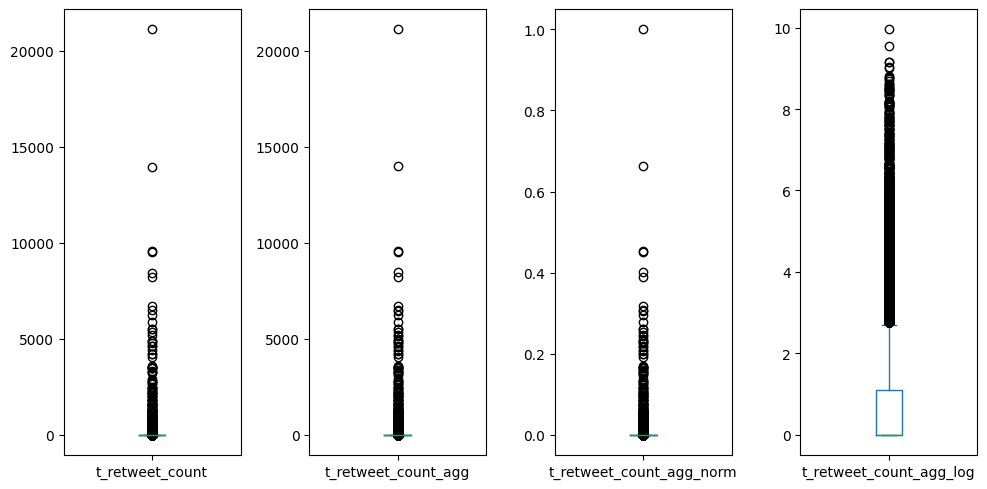

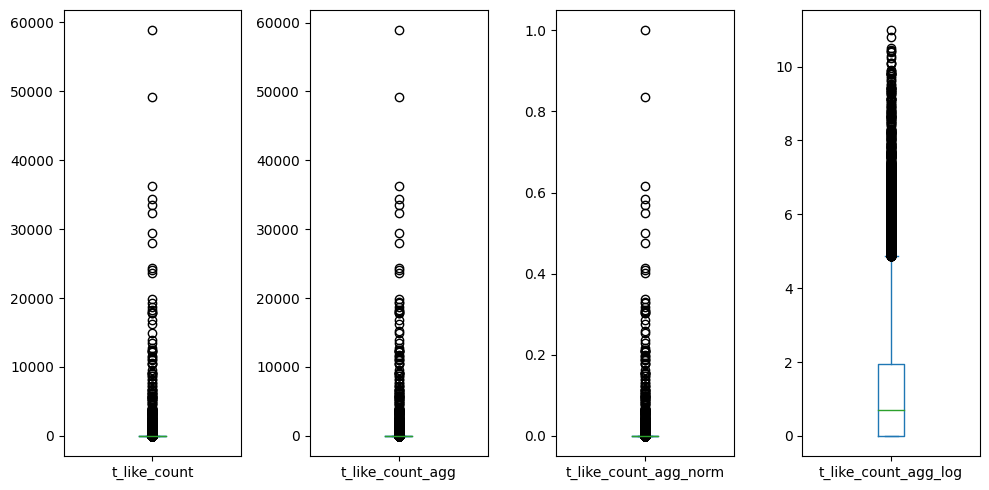

In [13]:
for col in ['t_retweet_count', 't_reply_count', 't_like_count']:
    fig, axs = plt.subplots(figsize=(10, 5), nrows=1, ncols=4)

    axes = df[[f'{col}', f'{col}_agg', f'{col}_agg_norm', f'{col}_agg_log']].plot(kind='box', subplots=True,legend=False, ax=axs)
    plot_names = ['RT Count', 'Reply Count', 'Like Count']
    # Add plot names to each subplot

    # Adjust the layout to prevent overlapping titles
    plt.tight_layout()

## Zero counts in the DVs

In [14]:
# Count the number of zeros in each column
zero_counts = df[['t_retweet_count_agg', 't_reply_count_agg', 't_like_count_agg', 't_quote_count_agg', 't_total_count_agg']].apply(lambda col: (col == 0).sum())

# Print the zero counts for each column
for col_name, count in zip(zero_counts.index, zero_counts.values):
    print(f"Number of zeros in '{col_name}': {count} - Proportion: {count/df.shape[0]}")

Number of zeros in 't_retweet_count_agg': 30604 - Proportion: 0.6121534584150098
Number of zeros in 't_reply_count_agg': 35467 - Proportion: 0.7094251310157219
Number of zeros in 't_like_count_agg': 20442 - Proportion: 0.40888906668800257
Number of zeros in 't_quote_count_agg': 43257 - Proportion: 0.8652438292595112
Number of zeros in 't_total_count_agg': 17303 - Proportion: 0.3461015321838621


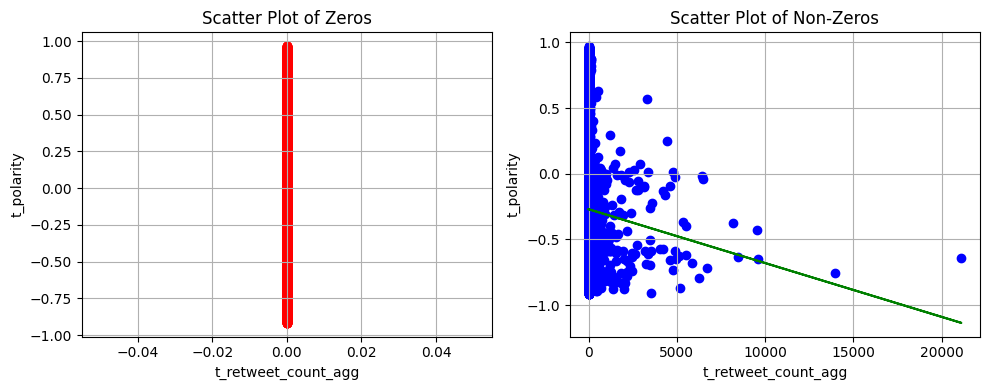

In [15]:
# Separate the data into zeros and non-zeros
zeros = df[(df['t_retweet_count_agg'] == 0)]
non_zeros = df[(df['t_retweet_count_agg'] != 0)]

# Create scatter plots for zeros and non-zeros
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(zeros['t_retweet_count_agg'], zeros['t_polarity'], color='red', label='Zeros')
plt.xlabel('t_retweet_count_agg')
plt.ylabel('t_polarity')
plt.title('Scatter Plot of Zeros')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(non_zeros['t_retweet_count_agg'], non_zeros['t_polarity'], color='blue', label='Non-Zeros')
plt.xlabel('t_retweet_count_agg')
plt.ylabel('t_polarity')
plt.title('Scatter Plot of Non-Zeros')

# Calculate and plot a regression line for non-zero data
slope, intercept, r_value, p_value, std_err = stats.linregress(non_zeros['t_retweet_count_agg'], non_zeros['t_polarity'])
x = np.array(non_zeros['t_retweet_count_agg'])
plt.plot(x, intercept + slope * x, color='green', label='Regression Line')

plt.grid(True)

plt.tight_layout()
plt.show()

## Potential outliers 

In [16]:
grouped_a_counts = df.groupby(['a_id', 'a_name'])[['t_retweet_count_agg', 'a_followers_count', 'a_following_count']] \
        .agg({'a_followers_count': 'mean', 't_retweet_count_agg': 'mean', 'a_following_count': 'mean'}) \
        .reset_index() \
        .rename(columns={'a_followers_count': 'a_followers_count_mean', 't_retweet_count_agg': 't_retweet_count_agg_mean', 'a_following_count': 'a_following_count_mean',})

top_10_folw = grouped_a_counts.nlargest(10, 'a_followers_count_mean')
top_10_folw['top'] = 'followers'
top_10_folle = grouped_a_counts.nlargest(10, 'a_following_count_mean')
top_10_folle['top'] = 'followees'

result_df = pd.concat([top_10_folw, top_10_folle])
#result_df.reset_index(drop=True, inplace=True)
result_df.sort_values(by=['t_retweet_count_agg_mean', 'a_followers_count_mean', 'a_following_count_mean',], ascending=False)

a_id                a_name  a_followers_count_mean  \
2524     22703645        Tucker Carlson           7642352.00000   
9506    292929271          Charlie Kirk           2250313.00000   
10179   341190477          Ricky Davila            405269.00000   
4745     50434933          LifeNews.com            294399.00000   
9346    279390084             Anonymous           7876207.00000   
7123    139162440         Patton Oswalt           4653504.00000   
5000     56312411        Sagarika Ghose           4118372.00000   
6337    101215084     Anjana Om Kashyap           4800954.00000   
1995     19929890           barkha dutt           7112975.00000   
2825     24733117      Jeffrey Levin 🇺🇦            657083.00000   
2973     25985333             NTV Kenya           4371225.00000   
14049  1115874631                  CGTN          13053180.00000   
8010    196415460         DANIEL NEWMAN            808858.00000   
4080     39743812        Economic Times           4318274.00000   
10509   366517094         George Cassis            246408.00000   
1844     19329393          Perez Hilton           5419738.00000   
7024    133769431              M LeMont            388397.00000   
1000     16383523       Algernon  Fross            284061.00000   
9588    298602588  Free Syria Media Hub            240349.00000   
13436   870012684          Chief Erican            228013.00000   

       t_retweet_count_agg_mean  a_following_count_mean        top  
2524                 2730.00000               172.00000  followers  
9506                 2678.00000            191592.00000  followees  
10179                 418.00000            193573.00000  followees  
4745                  248.87302            274028.00000  followees  
9346                  119.00000               916.00000  followers  
7123                   96.33333              4612.00000  followers  
5000                   56.00000               720.00000  followers  
6337                   47.00000              2012.00000  followers  
1995                   28.00000              4011.00000  followers  
2825                   24.12500            613637.00000  followees  
2973                   11.50000               370.00000  followers  
14049                   5.00000                76.00000  followers  
8010                    3.00000            569412.00000  followees  
4080                    2.00000                45.00000  followers  
10509                   2.00000            208157.00000  followees  
1844                    0.00000               537.00000  followers  
7024                    0.00000            414490.00000  followees  
1000                    0.00000            268222.00000  followees  
9588                    0.00000            224635.00000  followees  
13436                   0.00000            247792.00000  followees

In [17]:
df[df['t_retweet_count_agg'] > 10000][['a_name', 'a_id', 't_text']]

a_name                 a_id  \
40432  Olivia Julianna 🗳  1286356556741828608   
45075               𝐁𝐞𝐤𝐬  1432769984539893760   

                                                  t_text  
40432  Considering Ken Paxton is attempting to block ...  
45075  Two more pregnant children who were raped were...

In [18]:
df[df['t_reply_count_agg'] > 4000][['a_name', 'a_id', 't_text']]

a_name                 a_id  \
6903   Chip Franklin.com             48325671   
35823   Gretchen Whitmer  1093619068148559872   

                                                  t_text  
6903   What do you call a “Pro-Life Christian” who vo...  
35823                   Abortion is a fundamental right.

In [19]:
df[df['t_like_count_agg'] > 40000][['a_name', 'a_id', 't_text']]

a_name                 a_id  \
40432  Olivia Julianna 🗳  1286356556741828608   
45075               𝐁𝐞𝐤𝐬  1432769984539893760   

                                                  t_text  
40432  Considering Ken Paxton is attempting to block ...  
45075  Two more pregnant children who were raped were...

In [20]:
df[df['t_quote_count_agg'] > 1400][['a_name', 'a_id', 't_text']]

a_name                 a_id  \
45075   𝐁𝐞𝐤𝐬  1432769984539893760   

                                                  t_text  
45075  Two more pregnant children who were raped were...

# Transformation of the IDVs

## Standarise the covariates

In [21]:

# Extract the predictor variables and the response variable
predictors = ['a_followers_count', 'a_following_count', 'a_tweet_count', 'a_listed_count']
X = df[predictors]

# Initialize the StandardScaler
scaler = MinMaxScaler()

# Fit and transform the predictor variables
df.loc[:, (f"{col}_stand" for col in X.columns)] = scaler.fit_transform(X)

## Transform polarity

In [22]:
# Create new columns based on conditions
df.loc[:, 't_pol_pos'] = np.where((df['t_polarity'] >= 0) & (df['t_polarity'] <= 1), df['t_polarity'], 0)
df.loc[:, 't_pol_neg'] = abs(np.where((df['t_polarity'] >= -1) & (df['t_polarity'] < 0), df['t_polarity'], 0))

/tmp/ipykernel_54216/3797943241.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 't_pol_pos'] = np.where((df['t_polarity'] >= 0) & (df['t_polarity'] <= 1), df['t_polarity'], 0)
/tmp/ipykernel_54216/3797943241.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 't_pol_neg'] = abs(np.where((df['t_polarity'] >= -1) & (df['t_polarity'] < 0), df['t_polarity'], 0))


## Create the abortion - Miscarriage variable based on the text

In [23]:
abortion_keywords = ['abortion', 'feticide', 'foeticide', 'aborticide', 'fetal homicide', 'child destruction']
miscarriage_keywords = ['miscarriage', 'early pregnancy loss', 'stillbirth']
# Function to categorize text
def categorize_text(text):
    text = text.lower()
    if any(keyword in text for keyword in abortion_keywords) and any(keyword in text for keyword in miscarriage_keywords):
        return 'both'
    elif any(keyword in text for keyword in abortion_keywords):
        return 'abortion'
    elif any(keyword in text for keyword in miscarriage_keywords):
        return 'miscarriage'
    else:
        return 'neither'

# Apply the function to create a new column
df.loc[:, 'category'] = df['t_text'].apply(categorize_text)

# Display the resulting DataFrame
df['category'].value_counts()

/tmp/ipykernel_54216/417753708.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'category'] = df['t_text'].apply(categorize_text)


category
abortion       45933
miscarriage     3655
both             406
Name: count, dtype: int64

In [24]:
df.columns

Index(['t_id', 't_text', 't_retweet_count', 't_reply_count', 't_like_count',
       't_quote_count', 't_total_count', 't_retweet_count_agg',
       't_like_count_agg', 't_quote_count_agg', 't_reply_count_agg',
       't_total_count_agg', 't_topic', 't_polarity', 't_subjectivity',
       't_event', 't_event_noyear', 't_depression', 't_year', 'a_id', 'a_name',
       'a_gender', 'a_followers_count', 'a_following_count', 'a_tweet_count',
       'a_listed_count', 'a_verified_type', 't_retweet_count_agg_norm',
       't_retweet_count_agg_log', 't_reply_count_agg_norm',
       't_reply_count_agg_log', 't_like_count_agg_norm',
       't_like_count_agg_log', 'outliers', 'a_followers_count_stand',
       'a_following_count_stand', 'a_tweet_count_stand',
       'a_listed_count_stand', 't_pol_pos', 't_pol_neg', 'category'],
      dtype='object')

# Creating a subset column to sample perfect df

In [25]:
mask_sample = (((df['category'] == 'abortion') | (df['category'] == 'miscarriage')) & ((df['a_gender'] != 'Unclassified') & (df['a_gender'] != 'neutral')))
df.loc[:, 'analysis'] = mask_sample
df.groupby(['category', 'analysis']).size().reset_index(name='count')

/tmp/ipykernel_54216/4193989647.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'analysis'] = mask_sample


category  analysis  count
0     abortion     False  13877
1     abortion      True  32056
2         both     False    406
3  miscarriage     False   1088
4  miscarriage      True   2567

# Creating the dataframe with unique gender 

In [26]:
df.columns

Index(['t_id', 't_text', 't_retweet_count', 't_reply_count', 't_like_count',
       't_quote_count', 't_total_count', 't_retweet_count_agg',
       't_like_count_agg', 't_quote_count_agg', 't_reply_count_agg',
       't_total_count_agg', 't_topic', 't_polarity', 't_subjectivity',
       't_event', 't_event_noyear', 't_depression', 't_year', 'a_id', 'a_name',
       'a_gender', 'a_followers_count', 'a_following_count', 'a_tweet_count',
       'a_listed_count', 'a_verified_type', 't_retweet_count_agg_norm',
       't_retweet_count_agg_log', 't_reply_count_agg_norm',
       't_reply_count_agg_log', 't_like_count_agg_norm',
       't_like_count_agg_log', 'outliers', 'a_followers_count_stand',
       'a_following_count_stand', 'a_tweet_count_stand',
       'a_listed_count_stand', 't_pol_pos', 't_pol_neg', 'category',
       'analysis'],
      dtype='object')

In [37]:
df_analysis = df[df['analysis'] == True]
df_analysis.describe()

t_retweet_count  t_reply_count  t_like_count  t_quote_count  \
count      34623.00000    34623.00000   34623.00000    34623.00000   
mean          11.37380        3.22797      40.90382        0.76643   
std          195.83632       73.45119     687.85008       14.28684   
min            0.00000        0.00000       0.00000        0.00000   
25%            0.00000        0.00000       0.00000        0.00000   
50%            0.00000        0.00000       1.00000        0.00000   
75%            1.00000        1.00000       4.00000        0.00000   
max        21108.00000     8225.00000   58868.00000     1540.00000   

       t_total_count  t_retweet_count_agg  t_like_count_agg  \
count    34623.00000          34623.00000       34623.00000   
mean       188.64411             12.59198          43.71305   
std       2381.73692            205.08873         704.51832   
min          0.00000              0.00000           0.00000   
25%          0.00000              0.00000           0.00000   
50%          2.00000              0.00000           1.00000   
75%         13.00000              1.00000           5.00000   
max     113686.00000          21108.00000       58873.00000   

       t_quote_count_agg  t_reply_count_agg  t_total_count_agg  ...  \
count        34623.00000        34623.00000        34623.00000  ...   
mean             0.85608            3.41080           60.57190  ...   
std             14.99295           74.02392          946.76786  ...   
min              0.00000            0.00000            0.00000  ...   
25%              0.00000            0.00000            0.00000  ...   
50%              0.00000            0.00000            1.00000  ...   
75%              0.00000            1.00000            7.00000  ...   
max           1540.00000         8225.00000        73624.00000  ...   

       t_reply_count_agg_norm  t_reply_count_agg_log  t_like_count_agg_norm  \
count             34623.00000            34623.00000            34623.00000   
mean                  0.00041                0.36212                0.00074   
std                   0.00900                0.75279                0.01197   
min                   0.00000                0.00000                0.00000   
25%                   0.00000                0.00000                0.00000   
50%                   0.00000                0.00000                0.00002   
75%                   0.00012                0.69315                0.00008   
max                   1.00000                9.01506                1.00000   

       t_like_count_agg_log  a_followers_count_stand  a_following_count_stand  \
count           34623.00000              34623.00000              34623.00000   
mean                1.11740                  0.00102                  0.00538   
std                 1.46481                  0.00904                  0.02614   
min                 0.00000                  0.00000                  0.00000   
25%                 0.00000                  0.00002                  0.00057   
50%                 0.69315                  0.00008                  0.00166   
75%                 1.79176                  0.00029                  0.00474   
max                10.98315                  0.58548                  1.00000   

       a_tweet_count_stand  a_listed_count_stand   t_pol_pos   t_pol_neg  
count          34623.00000           34623.00000 34623.00000 34623.00000  
mean               0.01360               0.00291     0.02576     0.37848  
std                0.03205               0.01867     0.11801     0.30501  
min                0.00000               0.00000     0.00000     0.00000  
25%                0.00136               0.00003     0.00000     0.05720  
50%                0.00463               0.00018     0.00000     0.36099  
75%                0.01354               0.00087     0.00000     0.67354  
max                0.66869               0.86870     0.97092     0.91750  

[8 rows x 31 columns]

# Save the dataframe into feather to be open by R

In [27]:
final_data_folder = config['datasets']['pickle_folder']
df_R_data_filename = config['datasets']['df_R_filename']
df_R_data_file = f"{df_R_data_filename}_{sample_size}.feather"
df_R_data_location = os.path.join(final_data_folder, df_R_data_file)
feather.write_feather(df, df_R_data_location)

In [28]:
## This is used for the first hypothesis need to keep and clean later
#df_gender_event_unique = df.groupby(['a_id', 't_year', 't_event_noyear', 'a_gender']).size().reset_index().sort_values(by=0, ascending=False)
#df_gender_event_unique = df_gender_event_unique[(df_gender_event_unique['a_gender'] != 'neutral') & (df_gender_event_unique['a_gender'] != 'Unclassified')]
#print(f"Number of unique tweets: {len(df_gender_event_unique)}")